## Analyze A/B Test Results

## Table of Contents
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)




<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head(2)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0


b. Use the cell below to find the number of rows in the dataset.

In [3]:
rows_count = df.shape[0]
print('Number of rows = ',rows_count)

Number of rows =  294478


c. The number of unique users in the dataset.

In [4]:
unique_users = df.user_id.nunique()
print('The number of unique users = ',unique_users)

The number of unique users =  290584


d. The proportion of users converted.

In [5]:
prop_converted_users = df.converted.mean()
print('The proportion of converted users = ',prop_converted_users)

The proportion of converted users =  0.119659193556


e. The number of times the `new_page` and `treatment` don't match.

In [6]:
df.group.value_counts()

treatment    147276
control      147202
Name: group, dtype: int64

In [7]:
df.landing_page.value_counts()

new_page    147239
old_page    147239
Name: landing_page, dtype: int64

In [8]:
no_match = len(df.query('group == "control" & landing_page == "new_page"'))+ len(df.query('group == "treatment" & landing_page == "old_page"'))
print('The number of times new_page and treatment don\'t match =',no_match)

The number of times new_page and treatment don't match = 3893


f. Do any of the rows have missing values?

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


No missing Values in any row

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [10]:
df2 = df.query('(group == "treatment" & landing_page == "new_page") or (group == "control" & landing_page == "old_page")')
                

In [11]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [12]:
unique_users = df2.user_id.nunique()
print('Unique users in df2 =',unique_users)

Unique users in df2 = 290584


b. There is one **user_id** repeated in **df2**.  What is it?

In [13]:
duplicated_id = df2[df2.user_id.duplicated() == True].user_id.values[0]
print('the id of the repeated user is ' , duplicated_id)

the id of the repeated user is  773192


c. What is the row information for the repeat **user_id**? 

In [14]:
df2[df2.user_id.duplicated(keep=False) == True]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [15]:
df2 = df2.drop_duplicates(subset='user_id')
#check if the duplicate value still exist
df2.user_id.duplicated().unique()

array([False], dtype=bool)

`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [16]:
converted_prop = df2.converted.mean()
print('The probability of converted users = ',converted_prop)

The probability of converted users =  0.119597087245


b. Given that an individual was in the `control` group, what is the probability they converted?

In [17]:
conv_control_prop = df2[df2['group'] == 'control'].converted.mean()
conv_control_prop

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [18]:
conv_treat_prop = df2[df2['group'] == 'treatment'].converted.mean()
conv_treat_prop 

0.11880806551510564

d. What is the probability that an individual received the new page?

In [19]:
new_page_probability = len(df2.query('landing_page == "new_page"'))/df2.shape[0]
print('The probability of receiving the new page :',new_page_probability)

The probability of receiving the new page : 0.5000619442226688


e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

**Based on the results from the previous parts the numbers are very close between the control and the treatments groups and as a result to that there is no sufficient evidence that the new treatment page leads to more conversions**


<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**$H_{o}$ : $p_{new}$ - $p_{old} <= 0$** 

**$H_{1}$ : $p_{new}$ - $p_{old} > 0$** 



`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [20]:
#as they new page conversion rate is equal to the converted rate
# in ab_data.csv regardless of the page we will not filter the results
p_new = df2.converted.mean()
print('The new page conversion rate under null hypothesis : ',p_new)

The new page conversion rate under null hypothesis :  0.119597087245


b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [21]:
#as they old page conversion rate is equal to the converted rate
# in ab_data.csv regardless of the page we will not filter the results
p_old = df2.converted.mean()
print('The old page conversion rate under null hypothesis : ',p_old)

The old page conversion rate under null hypothesis :  0.119597087245


c. What is $n_{new}$, the number of individuals in the treatment group?

In [22]:
n_new = df2[df2['group']== 'treatment'].shape[0]
print('the number of individuals in the treatment group:',n_new)

the number of individuals in the treatment group: 145310


d. What is $n_{old}$, the number of individuals in the control group?

In [23]:
n_old = df2[df2['group']== 'control'].shape[0]
print('the number of individuals in the control group:',n_old)

the number of individuals in the control group: 145274


e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [24]:
#I am going to make simulation using random binomial 
new_page_converted = np.random.binomial(n=n_new ,p=p_new)
print('The new Page conversion after simulation :',new_page_converted)

The new Page conversion after simulation : 17378


f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [25]:
old_page_converted = np.random.binomial(n=n_old ,p=p_old)
print('The old Page conversion after simulation :',old_page_converted)

The old Page conversion after simulation : 17264


g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [26]:
p_new_simulated = new_page_converted/n_new
p_old_simulated = old_page_converted/n_old
print('The difference between new and old page after simulation :'
      ,p_new_simulated - p_old_simulated)

The difference between new and old page after simulation : 0.000755088085788988


h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [27]:
diffs=[]
for _ in range(10000):
    new_page_c = np.random.binomial(n=n_new ,p=p_new)
    old_page_c = np.random.binomial(n=n_old ,p=p_old)
    diff = (new_page_c/n_new) - (old_page_c/n_old)
    diffs.append(diff)
p_diffs=np.array(diffs)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

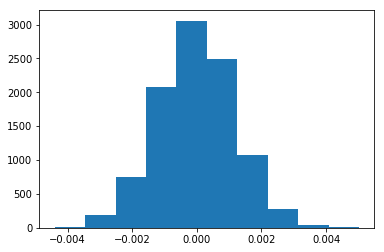

In [28]:
plt.hist(p_diffs);

The histogram shows normal distribution as expected we testing large sample sizes

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [44]:
#i will use the conv_treat_prop as the new page coversion and conv_control_prop
# as old page conversion from earlier
obs_diffs = conv_treat_prop - conv_control_prop
obs_diffs

-0.0015782389853555567

We can see that the observed difference located in the bulk of distribution 

In [43]:
print('The proportion of p_diffs greater than observed diffs :',(p_diffs > obs_diffs).mean())

The proportion of p_diffs greater than observed diffs : 0.905


k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**In this part we calculated the p_value based on the null hypothesis as in this case of $H_{o}$  we are calculating the left shaded region of our statistic which is the actual difference observed, and in this case the p_value is much larger than type1 error 0.05 which indicates that we should stick to the null hypothesis**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [30]:
import statsmodels.api as sm

convert_old = len(df2.query("landing_page == 'old_page' & converted == 1"))
convert_new = len(df2.query("landing_page == 'new_page' & converted == 1"))
n_old = len(df2[df2['landing_page'] == 'old_page'])
n_new = len(df2[df2['landing_page'] == 'new_page'])


/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [31]:
from statsmodels.stats.proportion import proportions_ztest
stat, pval = proportions_ztest([convert_old,convert_new],[n_old,n_new],alternative='smaller')
print('z-score is :',stat)
print('p_value is :',pval)


z-score is : 1.31092419842
p_value is : 0.905058312759


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**z-score here represents the standard deviation and when the z-score is not very high or very low(negative) and associated with high p_value , we can't reject the null hypothesis.
(The z-score critical range for 95% confidence level is < -1.96 or > +1.96)
and here they agree with the previous findings which suggests to stick with the null hypothsis**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Logistic Regression as it repesents categorical values**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [32]:
df2['intercept'] = 1
df2[['control','ab_page']] = pd.get_dummies(df2['group'])
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,control,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0


In [33]:
df2.drop('control',axis= 1,inplace=True)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [34]:
log_mod = sm.Logit(df2['converted'],df2[['intercept','ab_page']])
results = log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [35]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-10-22 08:38 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

**p_value associated with ab_page is 0.1899 which suggests to stay with the null hypothesis and it is different than in part 2 because in part2 the hypothesis is lower or greater than**

**$H_{o}$ : $p_{new}$ - $p_{old} <= 0$** 

**$H_{1}$ : $p_{new}$ - $p_{old} > 0$** 


**while in case of logistic regression the null and alternative hypothesis is double sided test either equal or not equal to each other**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Considering other factors in our test will lead to better conclusions and will show what are the exact factors affecting conversions , but some problems may appear like Multicollinearity when we have predictor variables that are correlated with one another ,which can lead to coefficients being flipped.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [36]:
df_countries = pd.read_csv('countries.csv')
df_countries.head(2)

,user_id,country
0,834778,UK
1,928468,US


In [37]:
df_new = df2.join(df_countries.set_index('user_id'),on='user_id',how='inner')
df_new.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US


In [38]:
df_new = df_new.join(pd.get_dummies(df_new['country']))
df_new.drop('country',axis=1,inplace=True)
df_new.head(1)

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,0,0,1


In [39]:
log_mod = sm.Logit(df_new['converted'],df_new[['intercept','UK','US']])
results = log_mod.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-10-22 08:38 AIC:              212780.8333
No. Observations:   290584           BIC:              212812.5723
Df Model:           2                Log-Likelihood:   -1.0639e+05
Df Residuals:       290581           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0375    0.0260  -78.3639  0.0000  -2.0885  -1.9866
UK             0.0507    0.0284    1.7863  0.0740  -0.0049   0.1064
US             0.0408    0.0269    1.5178  0.1291  -0.0119   0.0935
==================================================================

"""

In [40]:
np.exp(results.params)

intercept    0.130350
UK           1.052027
US           1.041647
dtype: float64

In [41]:
1/np.exp(results.params)

intercept    7.671651
UK           0.950546
US           0.960018
dtype: float64

**It appears that The conversion rate in US will be more than in CANADA While the conversion in UK will be slightly higher than US regardless of the page they receive**

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [63]:
df_new['UK_p_new']=df_new['UK']*df_new['ab_page']
df_new['US_p_new']=df_new['US']*df_new['ab_page']
df_new['CA_p_new']=df_new['CA']*df_new['ab_page']

log_mod2 = sm.Logit(df_new['converted'],df_new[['intercept','UK_p_new','US_p_new']])
results2 = log_mod2.fit()
results2.summary2()

Optimization terminated successfully.
         Current function value: 0.366117
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-10-21 14:04 AIC:              212781.7674
No. Observations:   290584           BIC:              212813.5064
Df Model:           2                Log-Likelihood:   -1.0639e+05
Df Residuals:       290581           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9926    0.0079  -252.9104  0.0000  -2.0081  -1.9772
UK_p_new      0.0112    0.0179     0.6256  0.5316  -0.0240   0.0464
US_p_new     -0.0144    0.0125    -1.1548  0.2482  -0.0389   0.0101
==================================================================

"""

In [88]:
np.exp(results2.params)

intercept    0.136338
UK_p_new     1.011292
US_p_new     0.985679
dtype: float64

In [89]:
1/np.exp(results2.params)

intercept    7.334699
UK_p_new     0.988834
US_p_new     1.014530
dtype: float64

**In case of receiving the new page The results shows slightly decrease in conversion rate in US and UK while very slighlt increase in CANADA**

### Conclusion :

The results shows statistically no significant difference in the conversion rate for the old and new page and that we should stay with old page regardless the country, However when the country variables are added a slight increase in conversion is observed in CANADA but practically it is not significant and is not enough to reject the null hypothesis 

In [45]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0